In [28]:
!pip install --upgrade pip
!pip install datasets torch transformers torchvision torchaudio requests "urllib3<2" scikit-learn matplotlib

In [29]:

import torch
from datasets import load_dataset, load_metric
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer, ResNetConfig, ResNetForImageClassification
import numpy as np


In [30]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
x = torch.ones(1).to(device)
print(x)

tensor([1.], device='mps:0')


In [31]:
def load_data():
    d_types = ['train','test','validation']
    datasets = []
    for d in d_types:
        datasets.append(load_dataset(
            'trpakov/chest-xray-classification',
            'full',
            split=d,
        ))
    return datasets

dataset_train, dataset_test, dataset_valid = load_data()
dataset_train


Found cached dataset chest-xray-classification (/Users/tommyluu/.cache/huggingface/datasets/trpakov___chest-xray-classification/full/1.0.0/395971eacf4f6d99e8b95f965fa0a8af5a31a5118529992bba3f60c4a7af1b92)
Found cached dataset chest-xray-classification (/Users/tommyluu/.cache/huggingface/datasets/trpakov___chest-xray-classification/full/1.0.0/395971eacf4f6d99e8b95f965fa0a8af5a31a5118529992bba3f60c4a7af1b92)
Found cached dataset chest-xray-classification (/Users/tommyluu/.cache/huggingface/datasets/trpakov___chest-xray-classification/full/1.0.0/395971eacf4f6d99e8b95f965fa0a8af5a31a5118529992bba3f60c4a7af1b92)


Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 12230
})

In [32]:
# check how many labels/number of classes
num_classes = len(set(dataset_train['labels']))
labels = dataset_train.features['labels'].names
num_classes, labels

(2, ['PNEUMONIA', 'NORMAL'])

In [33]:
# import feature extraction model
model_id = 'microsoft/resnet-50'

feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_id
)
config = ResNetConfig()
config.num_labels = num_classes
model = ResNetForImageClassification(config)
model = model.from_pretrained(
    model_id,  # classification head
).train().to(device)

In [34]:
def preprocess(batch):
    # take a list of PIL images and turn them to pixel values
    inputs = feature_extractor(
        batch['image'],
        return_tensors='pt'
    )
    # include the labels
    inputs['labels'] = batch['labels']
    return inputs

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

# transform the training dataset
prepared_train = dataset_train.with_transform(preprocess)
# ... and the testing dataset
prepared_test = dataset_test.with_transform(preprocess)
# ... and the validation dataset
prepared_valid = dataset_valid.with_transform(preprocess)

In [35]:
import numpy as np
from datasets import load_metric

# accuracy metric
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )


In [36]:
from transformers import Trainer

output_dir = './resnet_model'

# training the model
training_args = TrainingArguments(
  output_dir,
  per_device_train_batch_size=32,
  evaluation_strategy="steps",
  num_train_epochs=2,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=0.001,
  save_total_limit=2,
  optim='adamw_torch',
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor,
)

#change resume_from_checkpoint to True if you want to resume training
train_results = trainer.train(resume_from_checkpoint=False)
# save tokenizer with the model
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer state
trainer.save_state()
# evaluate with validation
metrics = trainer.evaluate(prepared_valid)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)


  1%|▏         | 10/766 [01:07<1:21:48,  6.49s/it]

{'loss': 4.715, 'learning_rate': 0.0009869451697127939, 'epoch': 0.03}


  3%|▎         | 20/766 [02:12<1:20:14,  6.45s/it]

{'loss': 0.5802, 'learning_rate': 0.0009738903394255875, 'epoch': 0.05}


  4%|▍         | 30/766 [03:16<1:18:20,  6.39s/it]

{'loss': 0.2781, 'learning_rate': 0.0009608355091383812, 'epoch': 0.08}


  5%|▌         | 40/766 [04:19<1:16:51,  6.35s/it]

{'loss': 0.2414, 'learning_rate': 0.0009477806788511749, 'epoch': 0.1}


  7%|▋         | 50/766 [05:24<1:18:05,  6.54s/it]

{'loss': 0.1592, 'learning_rate': 0.0009347258485639687, 'epoch': 0.13}


  8%|▊         | 60/766 [06:28<1:14:35,  6.34s/it]

{'loss': 0.1929, 'learning_rate': 0.0009216710182767625, 'epoch': 0.16}


  9%|▉         | 70/766 [07:32<1:14:19,  6.41s/it]

{'loss': 0.1253, 'learning_rate': 0.0009086161879895561, 'epoch': 0.18}


 10%|█         | 80/766 [08:36<1:12:31,  6.34s/it]

{'loss': 0.219, 'learning_rate': 0.00089556135770235, 'epoch': 0.21}


 12%|█▏        | 90/766 [09:39<1:11:42,  6.37s/it]

{'loss': 0.1913, 'learning_rate': 0.0008825065274151436, 'epoch': 0.23}


 13%|█▎        | 100/766 [10:45<1:11:52,  6.48s/it]

{'loss': 0.1239, 'learning_rate': 0.0008694516971279373, 'epoch': 0.26}


                                                   
 13%|█▎        | 100/766 [11:03<1:11:52,  6.48s/it]

{'eval_loss': 0.20632897317409515, 'eval_accuracy': 0.9243986254295533, 'eval_runtime': 17.3052, 'eval_samples_per_second': 33.631, 'eval_steps_per_second': 4.218, 'epoch': 0.26}


 14%|█▍        | 110/766 [12:10<1:16:15,  6.98s/it]

{'loss': 0.1571, 'learning_rate': 0.0008563968668407311, 'epoch': 0.29}


 16%|█▌        | 120/766 [13:16<1:10:12,  6.52s/it]

{'loss': 0.2204, 'learning_rate': 0.0008433420365535248, 'epoch': 0.31}


 17%|█▋        | 130/766 [14:24<1:11:36,  6.76s/it]

{'loss': 0.1548, 'learning_rate': 0.0008302872062663186, 'epoch': 0.34}


 18%|█▊        | 140/766 [15:31<1:09:27,  6.66s/it]

{'loss': 0.1371, 'learning_rate': 0.0008172323759791123, 'epoch': 0.37}


 20%|█▉        | 150/766 [16:36<1:06:33,  6.48s/it]

{'loss': 0.1254, 'learning_rate': 0.000804177545691906, 'epoch': 0.39}


 21%|██        | 160/766 [17:41<1:05:16,  6.46s/it]

{'loss': 0.1043, 'learning_rate': 0.0007911227154046997, 'epoch': 0.42}


 22%|██▏       | 170/766 [18:46<1:04:06,  6.45s/it]

{'loss': 0.1461, 'learning_rate': 0.0007780678851174935, 'epoch': 0.44}


 23%|██▎       | 180/766 [19:50<1:03:09,  6.47s/it]

{'loss': 0.1964, 'learning_rate': 0.0007650130548302873, 'epoch': 0.47}


 25%|██▍       | 190/766 [20:56<1:02:43,  6.53s/it]

{'loss': 0.1531, 'learning_rate': 0.0007519582245430809, 'epoch': 0.5}


 26%|██▌       | 200/766 [22:01<1:01:08,  6.48s/it]

{'loss': 0.1347, 'learning_rate': 0.0007389033942558748, 'epoch': 0.52}


                                                   
 26%|██▌       | 200/766 [22:18<1:01:08,  6.48s/it]

{'eval_loss': 0.42555058002471924, 'eval_accuracy': 0.8711340206185567, 'eval_runtime': 17.0979, 'eval_samples_per_second': 34.039, 'eval_steps_per_second': 4.27, 'epoch': 0.52}


 27%|██▋       | 210/766 [23:23<1:01:30,  6.64s/it]

{'loss': 0.1102, 'learning_rate': 0.0007258485639686684, 'epoch': 0.55}


 29%|██▊       | 220/766 [24:28<58:38,  6.44s/it]  

{'loss': 0.0715, 'learning_rate': 0.0007127937336814621, 'epoch': 0.57}


 30%|███       | 230/766 [25:32<57:28,  6.43s/it]

{'loss': 0.137, 'learning_rate': 0.000699738903394256, 'epoch': 0.6}


 31%|███▏      | 240/766 [26:36<56:23,  6.43s/it]

{'loss': 0.1009, 'learning_rate': 0.0006866840731070496, 'epoch': 0.63}


 33%|███▎      | 250/766 [27:40<54:59,  6.40s/it]

{'loss': 0.0932, 'learning_rate': 0.0006736292428198434, 'epoch': 0.65}


 34%|███▍      | 260/766 [28:44<54:09,  6.42s/it]

{'loss': 0.0872, 'learning_rate': 0.0006605744125326371, 'epoch': 0.68}


 35%|███▌      | 270/766 [29:49<53:01,  6.42s/it]

{'loss': 0.0992, 'learning_rate': 0.0006475195822454308, 'epoch': 0.7}


 37%|███▋      | 280/766 [30:51<49:38,  6.13s/it]

{'loss': 0.124, 'learning_rate': 0.0006344647519582245, 'epoch': 0.73}


 38%|███▊      | 290/766 [31:55<52:17,  6.59s/it]

{'loss': 0.0975, 'learning_rate': 0.0006214099216710183, 'epoch': 0.76}


 39%|███▉      | 300/766 [33:02<52:01,  6.70s/it]

{'loss': 0.0453, 'learning_rate': 0.0006083550913838121, 'epoch': 0.78}


                                                 
 39%|███▉      | 300/766 [33:20<52:01,  6.70s/it]

{'eval_loss': 0.18997333943843842, 'eval_accuracy': 0.9415807560137457, 'eval_runtime': 17.2697, 'eval_samples_per_second': 33.701, 'eval_steps_per_second': 4.227, 'epoch': 0.78}


 40%|████      | 310/766 [34:25<49:55,  6.57s/it]  

{'loss': 0.0417, 'learning_rate': 0.0005953002610966057, 'epoch': 0.81}


 42%|████▏     | 320/766 [35:27<45:31,  6.12s/it]

{'loss': 0.0781, 'learning_rate': 0.0005822454308093996, 'epoch': 0.84}


 43%|████▎     | 330/766 [36:28<45:14,  6.23s/it]

{'loss': 0.0405, 'learning_rate': 0.0005691906005221932, 'epoch': 0.86}


 44%|████▍     | 340/766 [37:30<43:57,  6.19s/it]

{'loss': 0.0954, 'learning_rate': 0.0005561357702349869, 'epoch': 0.89}


 46%|████▌     | 350/766 [38:30<42:01,  6.06s/it]

{'loss': 0.0896, 'learning_rate': 0.0005430809399477808, 'epoch': 0.91}


 47%|████▋     | 360/766 [39:33<42:19,  6.26s/it]

{'loss': 0.0702, 'learning_rate': 0.0005300261096605744, 'epoch': 0.94}


 48%|████▊     | 370/766 [40:36<41:13,  6.25s/it]

{'loss': 0.0268, 'learning_rate': 0.0005169712793733682, 'epoch': 0.97}


 50%|████▉     | 380/766 [41:39<40:26,  6.29s/it]

{'loss': 0.0615, 'learning_rate': 0.0005039164490861619, 'epoch': 0.99}


 51%|█████     | 390/766 [42:36<38:07,  6.08s/it]

{'loss': 0.0418, 'learning_rate': 0.0004908616187989556, 'epoch': 1.02}


 52%|█████▏    | 400/766 [43:37<36:54,  6.05s/it]

{'loss': 0.0385, 'learning_rate': 0.0004778067885117494, 'epoch': 1.04}


                                                 
 52%|█████▏    | 400/766 [43:55<36:54,  6.05s/it]

{'eval_loss': 0.10104292631149292, 'eval_accuracy': 0.9621993127147767, 'eval_runtime': 17.7609, 'eval_samples_per_second': 32.769, 'eval_steps_per_second': 4.11, 'epoch': 1.04}


 54%|█████▎    | 410/766 [44:56<37:16,  6.28s/it]  

{'loss': 0.0339, 'learning_rate': 0.00046475195822454307, 'epoch': 1.07}


 55%|█████▍    | 420/766 [45:57<34:57,  6.06s/it]

{'loss': 0.0255, 'learning_rate': 0.0004516971279373368, 'epoch': 1.1}


 56%|█████▌    | 430/766 [47:01<36:01,  6.43s/it]

{'loss': 0.0479, 'learning_rate': 0.0004386422976501306, 'epoch': 1.12}


 57%|█████▋    | 440/766 [48:04<33:22,  6.14s/it]

{'loss': 0.0532, 'learning_rate': 0.0004255874673629243, 'epoch': 1.15}


 59%|█████▊    | 450/766 [49:10<35:09,  6.67s/it]

{'loss': 0.0249, 'learning_rate': 0.00041253263707571804, 'epoch': 1.17}


 60%|██████    | 460/766 [50:15<33:18,  6.53s/it]

{'loss': 0.0228, 'learning_rate': 0.0003994778067885118, 'epoch': 1.2}


 61%|██████▏   | 470/766 [51:20<32:09,  6.52s/it]

{'loss': 0.0209, 'learning_rate': 0.00038642297650130547, 'epoch': 1.23}


 63%|██████▎   | 480/766 [52:23<30:18,  6.36s/it]

{'loss': 0.0377, 'learning_rate': 0.0003733681462140992, 'epoch': 1.25}


 64%|██████▍   | 490/766 [53:26<28:42,  6.24s/it]

{'loss': 0.0471, 'learning_rate': 0.000360313315926893, 'epoch': 1.28}


 65%|██████▌   | 500/766 [54:31<29:31,  6.66s/it]

{'loss': 0.0175, 'learning_rate': 0.0003472584856396867, 'epoch': 1.31}


                                                 
 65%|██████▌   | 500/766 [54:49<29:31,  6.66s/it]

{'eval_loss': 0.09605744481086731, 'eval_accuracy': 0.9707903780068728, 'eval_runtime': 17.6578, 'eval_samples_per_second': 32.96, 'eval_steps_per_second': 4.134, 'epoch': 1.31}


 67%|██████▋   | 510/766 [55:57<28:20,  6.64s/it]

{'loss': 0.0189, 'learning_rate': 0.00033420365535248044, 'epoch': 1.33}


 68%|██████▊   | 520/766 [57:02<26:02,  6.35s/it]

{'loss': 0.057, 'learning_rate': 0.0003211488250652741, 'epoch': 1.36}


 69%|██████▉   | 530/766 [58:04<24:46,  6.30s/it]

{'loss': 0.0346, 'learning_rate': 0.00030809399477806787, 'epoch': 1.38}


 70%|███████   | 540/766 [59:12<26:36,  7.06s/it]

{'loss': 0.0222, 'learning_rate': 0.0002950391644908616, 'epoch': 1.41}


 72%|███████▏  | 550/766 [1:00:23<25:37,  7.12s/it]

{'loss': 0.0379, 'learning_rate': 0.00028198433420365535, 'epoch': 1.44}


 73%|███████▎  | 560/766 [1:01:35<24:00,  6.99s/it]

{'loss': 0.0204, 'learning_rate': 0.0002689295039164491, 'epoch': 1.46}


 74%|███████▍  | 570/766 [1:02:45<23:43,  7.26s/it]

{'loss': 0.004, 'learning_rate': 0.00025587467362924284, 'epoch': 1.49}


 76%|███████▌  | 580/766 [1:03:59<22:48,  7.36s/it]

{'loss': 0.0231, 'learning_rate': 0.00024281984334203655, 'epoch': 1.51}


 77%|███████▋  | 590/766 [1:05:12<20:49,  7.10s/it]

{'loss': 0.0182, 'learning_rate': 0.0002297650130548303, 'epoch': 1.54}


 78%|███████▊  | 600/766 [1:06:20<18:23,  6.64s/it]

{'loss': 0.0106, 'learning_rate': 0.00021671018276762404, 'epoch': 1.57}


                                                   
 78%|███████▊  | 600/766 [1:06:39<18:23,  6.64s/it]

{'eval_loss': 0.09620027244091034, 'eval_accuracy': 0.9742268041237113, 'eval_runtime': 19.0085, 'eval_samples_per_second': 30.618, 'eval_steps_per_second': 3.84, 'epoch': 1.57}


 80%|███████▉  | 610/766 [1:07:46<18:39,  7.17s/it]

{'loss': 0.0514, 'learning_rate': 0.00020365535248041775, 'epoch': 1.59}


 81%|████████  | 620/766 [1:08:54<16:30,  6.78s/it]

{'loss': 0.0133, 'learning_rate': 0.0001906005221932115, 'epoch': 1.62}


 82%|████████▏ | 630/766 [1:09:59<14:45,  6.51s/it]

{'loss': 0.0086, 'learning_rate': 0.00017754569190600524, 'epoch': 1.64}


 84%|████████▎ | 640/766 [1:11:06<13:47,  6.57s/it]

{'loss': 0.0356, 'learning_rate': 0.00016449086161879895, 'epoch': 1.67}


 85%|████████▍ | 650/766 [1:12:12<12:39,  6.55s/it]

{'loss': 0.0071, 'learning_rate': 0.0001514360313315927, 'epoch': 1.7}


 86%|████████▌ | 660/766 [1:13:23<12:51,  7.28s/it]

{'loss': 0.0211, 'learning_rate': 0.00013838120104438644, 'epoch': 1.72}


 87%|████████▋ | 670/766 [1:14:32<11:06,  6.95s/it]

{'loss': 0.0318, 'learning_rate': 0.00012532637075718015, 'epoch': 1.75}


 89%|████████▉ | 680/766 [1:15:43<09:59,  6.97s/it]

{'loss': 0.0062, 'learning_rate': 0.00011227154046997389, 'epoch': 1.78}


 90%|█████████ | 690/766 [1:16:50<08:22,  6.62s/it]

{'loss': 0.0089, 'learning_rate': 9.921671018276762e-05, 'epoch': 1.8}


 91%|█████████▏| 700/766 [1:17:56<07:14,  6.59s/it]

{'loss': 0.0102, 'learning_rate': 8.616187989556136e-05, 'epoch': 1.83}


                                                   
 91%|█████████▏| 700/766 [1:18:14<07:14,  6.59s/it]

{'eval_loss': 0.07509122788906097, 'eval_accuracy': 0.9742268041237113, 'eval_runtime': 18.5744, 'eval_samples_per_second': 31.333, 'eval_steps_per_second': 3.93, 'epoch': 1.83}


 93%|█████████▎| 710/766 [1:19:22<06:24,  6.86s/it]

{'loss': 0.0157, 'learning_rate': 7.310704960835509e-05, 'epoch': 1.85}


 94%|█████████▍| 720/766 [1:20:28<05:02,  6.57s/it]

{'loss': 0.0091, 'learning_rate': 6.005221932114883e-05, 'epoch': 1.88}


 95%|█████████▌| 730/766 [1:21:36<04:01,  6.70s/it]

{'loss': 0.0074, 'learning_rate': 4.6997389033942557e-05, 'epoch': 1.91}


 97%|█████████▋| 740/766 [1:22:42<02:51,  6.60s/it]

{'loss': 0.0117, 'learning_rate': 3.39425587467363e-05, 'epoch': 1.93}


 98%|█████████▊| 750/766 [1:23:49<01:48,  6.79s/it]

{'loss': 0.0055, 'learning_rate': 2.0887728459530027e-05, 'epoch': 1.96}


 99%|█████████▉| 760/766 [1:25:00<00:43,  7.33s/it]

{'loss': 0.003, 'learning_rate': 7.83289817232376e-06, 'epoch': 1.98}


100%|██████████| 766/766 [1:25:35<00:00,  6.70s/it]


{'train_runtime': 5135.7938, 'train_samples_per_second': 4.763, 'train_steps_per_second': 0.149, 'train_loss': 0.14013190246029092, 'epoch': 2.0}
***** train metrics *****
  epoch                    =        2.0
  train_loss               =     0.1401
  train_runtime            = 1:25:35.79
  train_samples_per_second =      4.763
  train_steps_per_second   =      0.149


100%|██████████| 146/146 [00:36<00:00,  3.96it/s]

***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.9785
  eval_loss               =      0.057
  eval_runtime            = 0:00:37.14
  eval_samples_per_second =     31.367
  eval_steps_per_second   =      3.931


Text(0.5, 1.0, 'ResNet50: Loss over train steps')

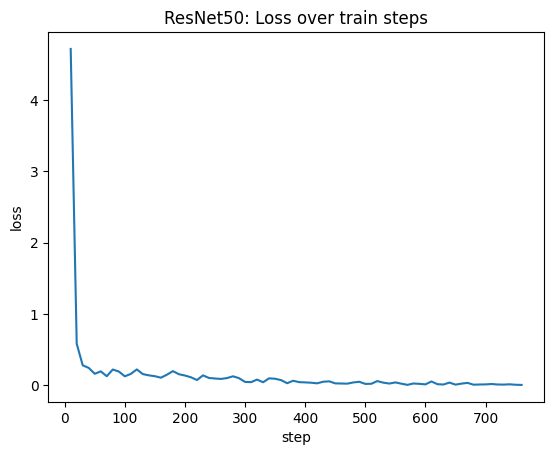

In [37]:
from matplotlib import pyplot as plt

x = [log['step'] for log in trainer.state.log_history if 'loss' in log]
y = [log['loss'] for log in trainer.state.log_history if 'loss' in log]


# y axis is loss
# x axis is step
plt.plot(x, y)
plt.xlabel('step')
plt.ylabel('loss')
plt.title('ResNet50: Loss over train steps')
